In [1]:
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
                    .master('local[2]') \
                    .appName('Practice 1 ') \
                    .getOrCreate()

spark

In [3]:
path = 'S://Datasets/csv/ipl2.csv'

In [4]:
ipl = spark.read.csv(path=path, header=True,inferSchema=True)

In [5]:
ipl.show(3)

+---+------+----------+-------------------+--------------------+--------------------+--------------------+-------------+------+----------+--------------------+-----------+--------------+---------------+--------------------+---------+--------------+-------+
| id|season|      city|        played_date|               team1|               team2|         toss_winner|toss_decision|result|dl_applied|              winner|win_by_runs|win_by_wickets|player_of_match|               venue|  umpire1|       umpire2|umpire3|
+---+------+----------+-------------------+--------------------+--------------------+--------------------+-------------+------+----------+--------------------+-----------+--------------+---------------+--------------------+---------+--------------+-------+
|  1|  2008| Bangalore|2008-04-18 00:00:00|Kolkata Knight Ri...|Royal Challengers...|Royal Challengers...|        field|normal|         0|Kolkata Knight Ri...|        140|             0|    BB McCullum|M Chinnaswamy Sta...|Asad R

In [6]:
ipl.printSchema()

root
 |-- id: integer (nullable = true)
 |-- season: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- played_date: timestamp (nullable = true)
 |-- team1: string (nullable = true)
 |-- team2: string (nullable = true)
 |-- toss_winner: string (nullable = true)
 |-- toss_decision: string (nullable = true)
 |-- result: string (nullable = true)
 |-- dl_applied: integer (nullable = true)
 |-- winner: string (nullable = true)
 |-- win_by_runs: integer (nullable = true)
 |-- win_by_wickets: integer (nullable = true)
 |-- player_of_match: string (nullable = true)
 |-- venue: string (nullable = true)
 |-- umpire1: string (nullable = true)
 |-- umpire2: string (nullable = true)
 |-- umpire3: string (nullable = true)



### No. of Matches Played in each season (year)

In [7]:
from pyspark.sql.functions import *


In [8]:
Matches_per_season = ipl.groupBy('season').agg(countDistinct('id').alias('total_matches')).sort('season')
Matches_per_season.show()

+------+-------------+
|season|total_matches|
+------+-------------+
|  2008|           58|
|  2009|           57|
|  2010|           60|
|  2011|           73|
|  2012|           74|
|  2013|           76|
|  2014|           60|
|  2015|           59|
|  2016|           60|
+------+-------------+



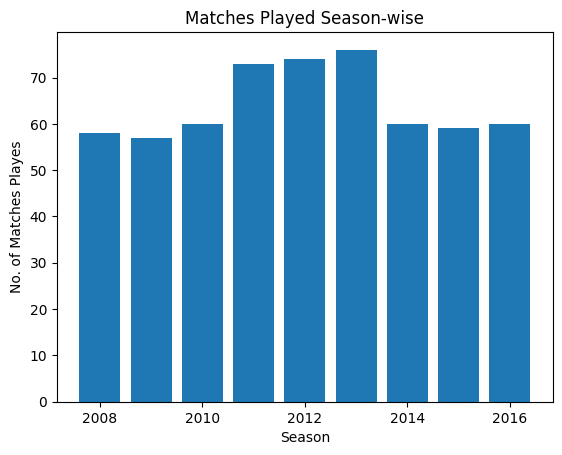

In [9]:
x=Matches_per_season.toPandas()['season'].tolist()
y=Matches_per_season.toPandas()['total_matches'].tolist()

plt.bar(x,y)

plt.title('Matches Played Season-wise')
plt.xlabel('Season')
plt.ylabel( 'No. of Matches Playes')

plt.show()

### No. of matches won by team batting first & team batting second!

In [10]:
ipl.createOrReplaceTempView('table1')

##### sql query

In [11]:
df2 = spark.sql('SELECT  "Batted Second" as win_type,  SUM(CASE WHEN win_by_wickets > 0 THEN 1 ELSE 0 END) as matches FROM table1' ) 
df3 = spark.sql('SELECT  "Batted First" as win_type,  SUM(CASE WHEN win_by_runs > 0 THEN 1 ELSE 0 END) as matches FROM table1')
df4 = spark.sql('SELECT  "Tied" as win_type,  SUM(CASE WHEN win_by_runs = 0 AND win_by_wickets =0 THEN 1 ELSE 0 END) as matches FROM table1')
df2=df2.union(df4).union(df3)
df2.show()

+-------------+-------+
|     win_type|matches|
+-------------+-------+
|Batted Second|    307|
|         Tied|      9|
| Batted First|    261|
+-------------+-------+



##### pyspark

In [12]:
df2=ipl.select('win_by_runs','win_by_wickets') .withColumn('Match_Result', when(ipl['win_by_runs'] > 0,'Batted First').when (ipl['win_by_wickets']>0,'Batted Second')\
                                                      .otherwise('Tied')) \
                                            .groupBy('Match_Result').count()
df2.show()

+-------------+-----+
| Match_Result|count|
+-------------+-----+
|Batted Second|  307|
|         Tied|    9|
| Batted First|  261|
+-------------+-----+



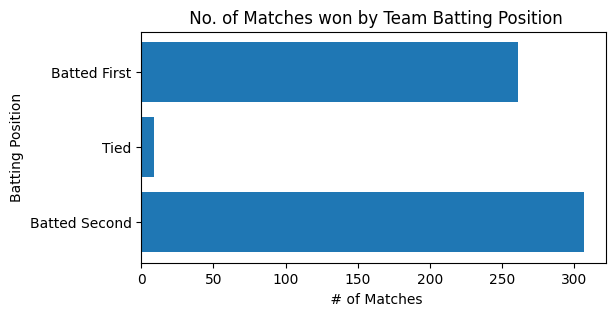

In [13]:
x = df2.toPandas()['Match_Result']
y = df2.toPandas()['count']

plt.figure(figsize=(6, 3))
plt.barh(x,y)

plt.title(' No. of Matches won by Team Batting Position')
plt.xlabel(' # of Matches')
plt.ylabel('Batting Position')

plt.show()

### Team wise - Played ,Won matches and Winning Percentage

In [14]:
ipl.select('team1','team2','toss_winner','toss_decision','winner').show(3)

+--------------------+--------------------+--------------------+-------------+--------------------+
|               team1|               team2|         toss_winner|toss_decision|              winner|
+--------------------+--------------------+--------------------+-------------+--------------------+
|Kolkata Knight Ri...|Royal Challengers...|Royal Challengers...|        field|Kolkata Knight Ri...|
| Chennai Super Kings|     Kings XI Punjab| Chennai Super Kings|          bat| Chennai Super Kings|
|    Rajasthan Royals|    Delhi Daredevils|    Rajasthan Royals|          bat|    Delhi Daredevils|
+--------------------+--------------------+--------------------+-------------+--------------------+
only showing top 3 rows



In [15]:
PM =ipl.groupBy('team1').count().union(ipl.groupBy('team2').count()).groupBy('team1').agg(sum('count').alias('Played_matches'))
PM.show()

WM=ipl.groupBy('winner').count().withColumnRenamed('count','Won_Matches')
WM.show()

+--------------------+--------------+
|               team1|Played_matches|
+--------------------+--------------+
| Sunrisers Hyderabad|            62|
| Chennai Super Kings|           131|
|     Deccan Chargers|            75|
|Kochi Tuskers Kerala|            14|
|    Rajasthan Royals|           118|
|       Gujarat Lions|            16|
|Royal Challengers...|           139|
|Kolkata Knight Ri...|           132|
|Rising Pune Super...|            14|
|     Kings XI Punjab|           134|
|       Pune Warriors|            46|
|    Delhi Daredevils|           133|
|      Mumbai Indians|           140|
+--------------------+--------------+

+--------------------+-----------+
|              winner|Won_Matches|
+--------------------+-----------+
| Sunrisers Hyderabad|         34|
| Chennai Super Kings|         79|
|                null|          3|
|     Deccan Chargers|         29|
|Kochi Tuskers Kerala|          6|
|    Rajasthan Royals|         63|
|       Gujarat Lions|          9|
|Ro

In [16]:
df3 =PM.join(WM,PM['team1']==WM['winner'],how='inner')\
           .select('team1','Played_matches','Won_Matches',round(WM['Won_Matches']/ PM['Played_matches'],2))
df3.show() #.select ("*,'Played_matches'/'Won_Matches'")

+--------------------+--------------+-----------+----------------------------------------+
|               team1|Played_matches|Won_Matches|round((Won_Matches / Played_matches), 2)|
+--------------------+--------------+-----------+----------------------------------------+
| Sunrisers Hyderabad|            62|         34|                                    0.55|
| Chennai Super Kings|           131|         79|                                     0.6|
|     Deccan Chargers|            75|         29|                                    0.39|
|Kochi Tuskers Kerala|            14|          6|                                    0.43|
|    Rajasthan Royals|           118|         63|                                    0.53|
|       Gujarat Lions|            16|          9|                                    0.56|
|Royal Challengers...|           139|         70|                                     0.5|
|Kolkata Knight Ri...|           132|         68|                                    0.52|

In [17]:
## sorted by highest winning percentage
cols = ['Team', 'Matches Played', 'Matches Won', 'Winning Percentage']
df3=df3.toDF(*cols).sort(['Winning Percentage'],ascending=0)

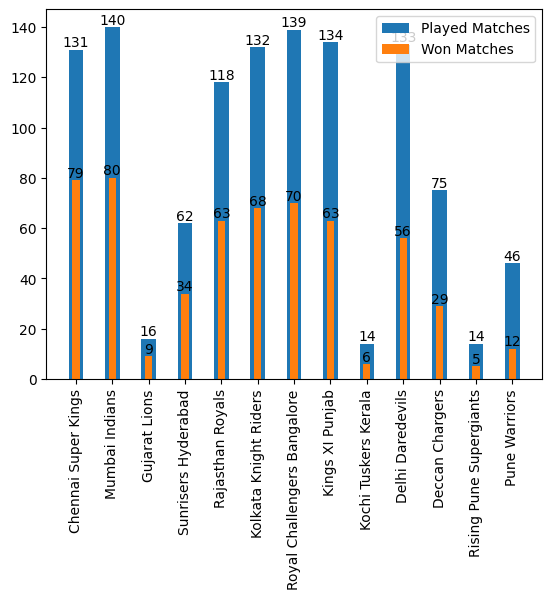

In [18]:
Team=df3.toPandas()['Team'].tolist()
total_matches=df3.toPandas()['Matches Played'].tolist()
won_matches=df3.toPandas()['Matches Won'].tolist()
winning_percentage=df3.toPandas()['Winning Percentage'].tolist()


fig,ax = plt.subplots()

bar1=ax.bar(Team,total_matches,0.4,label='Played Matches')
bar2=ax.bar(Team,won_matches,0.2,label='Won Matches')
ax.bar_label(bar1)
ax.bar_label(bar2)

plt.xticks(rotation='vertical')

ax.legend(loc='best')
plt.show()

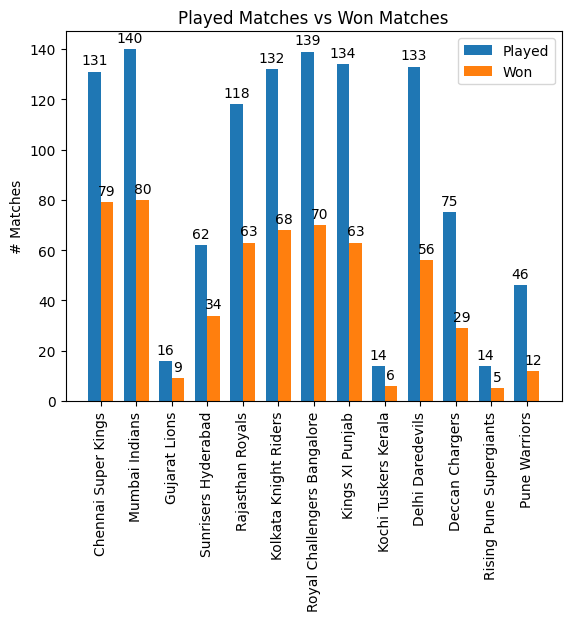

In [19]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(len(Team))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, total_matches, width, label='Played')
rects2 = ax.bar(x + width/2, won_matches, width, label='Won')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# Matches')

ax.set_title('Played Matches vs Won Matches')
             
ax.set_xticks(x, Team,rotation='vertical')
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)



plt.show()

### Toss Winning Percentage Overall


In [20]:
df=ipl.groupBy('toss_winner').count().withColumnRenamed('count','toss_won').sort('toss_won',ascending=0)
df.show()

+--------------------+--------+
|         toss_winner|toss_won|
+--------------------+--------+
|      Mumbai Indians|      74|
|Kolkata Knight Ri...|      69|
| Chennai Super Kings|      66|
|     Kings XI Punjab|      64|
|    Delhi Daredevils|      64|
|    Rajasthan Royals|      63|
|Royal Challengers...|      61|
|     Deccan Chargers|      43|
| Sunrisers Hyderabad|      30|
|       Pune Warriors|      20|
|Kochi Tuskers Kerala|       8|
|       Gujarat Lions|       8|
|Rising Pune Super...|       7|
+--------------------+--------+



In [21]:
df=df.toPandas()
total=df['toss_won'].sum()

12.824957072734833
11.958405375480652
11.43847480416298
11.09185442328453
11.09185442328453
10.918544232845306
10.571923851966858
7.452339679002762
5.199306830763817
3.4662045538425446
1.3864818029105663
1.3864818029105663
1.213171612471342


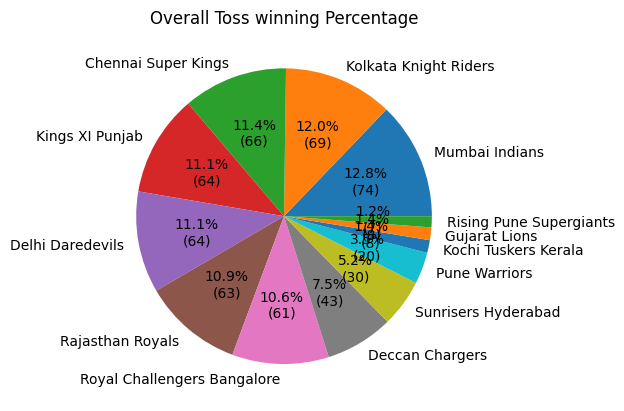

In [22]:
def my_fmt(x):
    print(x)
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)


fig,ax=plt.subplots()
ax.pie(x=df['toss_won'].tolist(), labels=df['toss_winner'],autopct=my_fmt)
plt.title('Overall Toss winning Percentage')
plt.show()

### Toss winning percentage against no. of played matches!

In [23]:
PM =ipl.groupBy('team1').count().union(ipl.groupBy('team2').count()).groupBy('team1').agg(sum('count')).withColumnRenamed('sum(count)','Played_matches')
TW=ipl.groupBy('toss_winner').count().withColumnRenamed('count','toss_won').sort('toss_won',ascending=0)

TW.show(2)
PM.show(2)

+--------------------+--------+
|         toss_winner|toss_won|
+--------------------+--------+
|      Mumbai Indians|      74|
|Kolkata Knight Ri...|      69|
+--------------------+--------+
only showing top 2 rows

+-------------------+--------------+
|              team1|Played_matches|
+-------------------+--------------+
|Sunrisers Hyderabad|            62|
|Chennai Super Kings|           131|
+-------------------+--------------+
only showing top 2 rows



In [24]:
df=PM.join(TW,PM.team1==TW.toss_winner,how='left').select("team1","Played_matches","toss_won")
df=df.withColumn("pcntg",round(100* df['toss_won'] / df['Played_matches'] , 2))
df.show(2)

+-------------------+--------------+--------+-----+
|              team1|Played_matches|toss_won|pcntg|
+-------------------+--------------+--------+-----+
|Sunrisers Hyderabad|            62|      30|48.39|
|Chennai Super Kings|           131|      66|50.38|
+-------------------+--------------+--------+-----+
only showing top 2 rows



In [25]:
df=df.toPandas().sort_values(by=['pcntg'],ascending=False)
df.head()

,team1,Played_matches,toss_won,pcntg
2,Deccan Chargers,75,43,57.33
3,Kochi Tuskers Kerala,14,8,57.14
4,Rajasthan Royals,118,63,53.39
12,Mumbai Indians,140,74,52.86
7,Kolkata Knight Riders,132,69,52.27


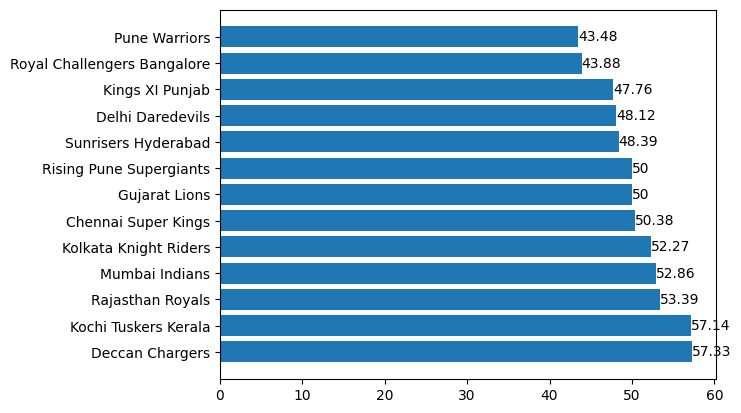

In [26]:
fig,ax=plt.subplots()

ax.barh(df['team1'],df['pcntg'])
ax.bar_label(ax.containers[0])
plt.show()

### THE END